In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import matplotlib.pyplot
import numpy as np

In [3]:
tf.config.set_visible_devices([], 'GPU')

In [4]:
import random

class DataGenerator(keras.utils.Sequence):
    def __init__(self, templates, messages, n_channels=5, sequence_length=50, batch_size=32, shuffle=True):
        self.n_channels = n_channels
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.batch_half_size = batch_size // 2
        self.shuffle=shuffle
        self.character_mappings = {
          'a': [0, 0, 0, 0, 1],
          'b': [0, 0, 0, 1, 0],
          'c': [0, 0, 0, 1, 1],
          'd': [0, 0, 1, 0, 0],
          'e': [0, 0, 1, 0, 1],
          'f': [0, 0, 1, 1, 0],
          'g': [0, 0, 1, 1, 1],
          'h': [0, 1, 0, 0, 0],
          'i': [0, 1, 0, 0, 1],
          'j': [0, 1, 0, 1, 0],
          'k': [0, 1, 0, 1, 1],
          'l': [0, 1, 1, 0, 0],
          'm': [0, 1, 1, 0, 1],
          'n': [0, 1, 1, 1, 0],
          'o': [0, 1, 1, 1, 1],
          'p': [1, 0, 0, 0, 0],
          'q': [1, 0, 0, 0, 1],
          'r': [1, 0, 0, 1, 0],
          's': [1, 0, 0, 1, 1],
          't': [1, 0, 1, 0, 0],
          'u': [1, 0, 1, 0, 1],
          'v': [1, 0, 1, 1, 0],
          'w': [1, 0, 1, 1, 1],
          'x': [1, 1, 0, 0, 0],
          'y': [1, 1, 0, 0, 1],
          'z': [1, 1, 0, 1, 0],
          ' ': [1, 1, 0, 1, 1],
        }
        with open('greetings.txt', 'r') as file:
            self.greetings = file.read().split('\n')
        with open('verbs.txt', 'r') as file:
            self.verbs = file.read().split('\n')
        with open('technologies.txt', 'r') as file:
            self.technologies = file.read().split('\n')
        with open('subjects.txt', 'r') as file:
            self.subjects = file.read().split('\n')
        with open(templates, 'r', encoding='utf-8') as file:
            self.templates = file.read().split('\n')
        with open(messages, 'r', encoding='utf-8') as file:
            self.messages = file.read().split('\n')
        self.on_epoch_end()

    def generate_message(self):
        msg_template = random.choice(self.templates)
        tokens = msg_template.split(' ')
        final = ''
        tech = random.choice(self.technologies)
        if random.randint(0, 2) == 0:
            final += random.choice(self.greetings) + ' '
        for t in tokens:
            if t == '<verb>':
                final += random.choice(self.verbs) + ' '
            elif t == '<subject>':
                final += random.choice(self.subjects) + ' '
            elif t == '<technology>':
                final += tech + ' '
            else:
                final += t + ' '
        return final[:-1]

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.messages))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def mutate(self, msg):
        final = ''
        for e in msg:
            r = random.randint(0, 74) # 1/75 chance of mutation
            if r == 0:
                continue
            elif r == 1:
                final += e + e
            else:
                final += e
        return final

    def vectorize_message(self, msg):
        vec = []
        for c in msg:
            if len(vec) == self.sequence_length * self.n_channels:
                return vec
            if self.character_mappings.get(c) is not None:
                vec += self.character_mappings[c]
        while len(vec) < self.sequence_length * self.n_channels:
            vec += [0, 0, 0, 0, 0]
        return vec

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, self.sequence_length * self.n_channels))

        zeros = np.zeros((self.batch_size // 2))
        ones = np.ones((self.batch_size // 2))

        y = np.concatenate((zeros, ones))
        np.random.shuffle(y)

        itr_fmsg = iter(indexes)
        for index, e in enumerate(y):
            msg = self.mutate(self.generate_message()) if e else self.messages[next(itr_fmsg)]
            X[index] = self.vectorize_message(msg)

        return X, y

    def __len__(self):
        return int((len(self.messages) * 2 / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_half_size:(index+1)*self.batch_half_size]

        X, y = self.__data_generation(indexes)

        return X, y

In [43]:
sequence_length = 50
n_channels = 5
batch_size = 32

params = {
    'n_channels': n_channels,
    'sequence_length': sequence_length,
    'batch_size': batch_size,
    'shuffle': True
}

train_generator = DataGenerator(templates='train_templates.txt', messages='train_messages.txt', **params)
val_generator = DataGenerator(templates='val_templates.txt', messages='val_messages.txt', **params)

In [49]:
model = keras.Sequential()

model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros', input_dim=sequence_length*n_channels))
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1))

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=[keras.metrics.BinaryAccuracy()]
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 512)               128512    
                                                                 
 dense_46 (Dense)            (None, 256)               131328    
                                                                 
 dense_47 (Dense)            (None, 128)               32896     
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dense_49 (Dense)            (None, 16)                1040      
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                                 
Total params: 302,049
Trainable params: 302,049
Non-t

In [51]:
history = model.fit(train_generator, validation_data=val_generator, epochs=20)

Epoch 1/20
2550/2550 [==============================] - 4s 2ms/step - loss: 0.2392 - binary_accuracy: 0.8987 - val_loss: 0.2742 - val_binary_accuracy: 0.8624
Epoch 2/20
2550/2550 [==============================] - 4s 1ms/step - loss: 0.1123 - binary_accuracy: 0.9577 - val_loss: 0.2442 - val_binary_accuracy: 0.8943
Epoch 3/20
2550/2550 [==============================] - 4s 2ms/step - loss: 0.0726 - binary_accuracy: 0.9730 - val_loss: 0.2813 - val_binary_accuracy: 0.8890
Epoch 4/20
2550/2550 [==============================] - 4s 1ms/step - loss: 0.0526 - binary_accuracy: 0.9810 - val_loss: 0.3198 - val_binary_accuracy: 0.8757
Epoch 5/20
2550/2550 [==============================] - 4s 1ms/step - loss: 0.0397 - binary_accuracy: 0.9852 - val_loss: 0.3763 - val_binary_accuracy: 0.8670
Epoch 6/20
2550/2550 [==============================] - 4s 2ms/step - loss: 0.0323 - binary_accuracy: 0.9889 - val_loss: 0.2410 - val_binary_accuracy: 0.9156
Epoch 7/20
2550/2550 [==============================

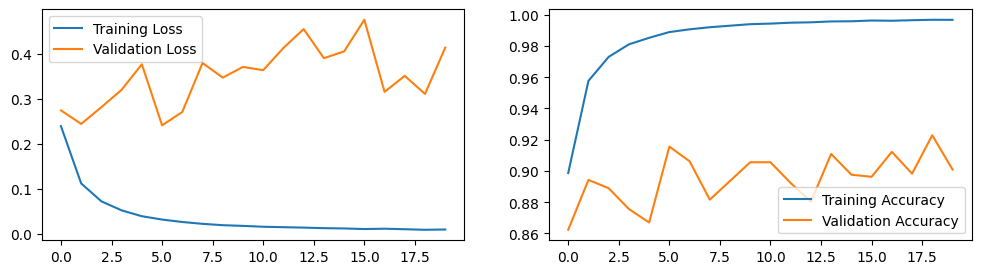

In [52]:
import matplotlib.pyplot as plt

h_dic = history.history

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(h_dic['loss'], label='Training Loss')
plt.plot(h_dic['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h_dic['binary_accuracy'], label='Training Accuracy')
plt.plot(h_dic['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [53]:
export_model = keras.Sequential([
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=1e-4)
)

In [30]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(export_model, 'model/')

ImportError: cannot import name 'load_op' from 'tensorflow.python.data.ops' (/Users/fahd/miniconda/lib/python3.10/site-packages/tensorflow/python/data/ops/__init__.py)

In [54]:
export_model.save('model.h5')